<a href="https://colab.research.google.com/github/plthiyagu/Personnel/blob/master/Rock_Paper_Scissor_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub


import os
import numpy as np




import platform
import datetime
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

import tensorflow_datasets as tfds

Python version: 3.6.9
Tensorflow version: 2.3.0
Keras version: 2.4.0


In [40]:
%load_ext tensorboard

In [42]:
# Clear any logs from previous runs.
!rm -rf ./logs/

In [41]:
tf.__version__

'2.3.0'

In [44]:
# See available datasets
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'gr

In [3]:
datasets,info = tfds.load(name='rock_paper_scissors',with_info=True, as_supervised=True, split=['train','test'])

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteV14990/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteV14990/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

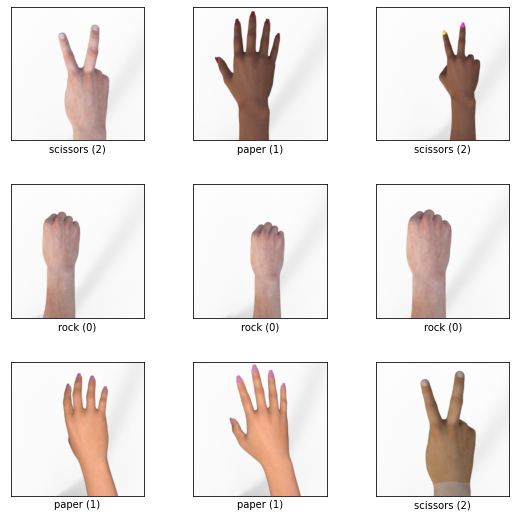

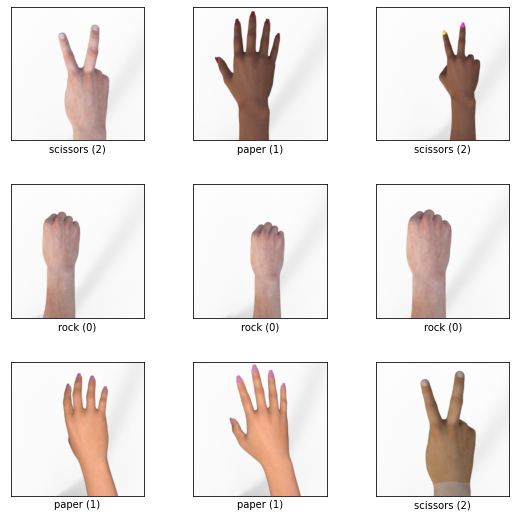

In [6]:
train,info_train=tfds.load(name='rock_paper_scissors',with_info=True,split='test')
tfds.show_examples(info_train,train)

In [8]:
dataset = datasets[0].concatenate(datasets[1])
dataset = dataset.shuffle(3000)

In [9]:
rsp_val= dataset.take(600)
rsp_test_temp=dataset.skip(600)
rsp_test=rsp_test_temp.take(400)
rsp_train=rsp_test_temp.skip(400)

In [10]:
len(list(rsp_train))

1892

In [12]:
def scale(image,label):
  image= tf.cast(image,tf.float32)
  image /=255.0

  return tf.image.resize(image,[224,224]),tf.one_hot(label,3)

In [13]:
def get_dataset(batch_size=64):
  train_dataset_scaled= rsp_train.map(scale).shuffle(1900).batch(batch_size)
  test_dataset_scaled= rsp_test.map(scale).shuffle(batch_size)
  val_dataset_scaled= rsp_val.map(scale).batch(batch_size)
  return train_dataset_scaled,test_dataset_scaled,val_dataset_scaled

In [14]:
train_dataset,test_dataset,val_dataset=get_dataset()
train_dataset.cache()
val_dataset.cache()

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [17]:
feature_extractor= "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [18]:
feature_extraction_layer=hub.KerasLayer(feature_extractor,input_shape=(224,224,3))


In [19]:
feature_extraction_layer.trainable=False

In [22]:
model =tf.keras.Sequential([
                            feature_extraction_layer,
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(3,activation='softmax')

])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [24]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()


In [25]:
train_dataset

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [26]:
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_dataset, epochs=2, validation_data=val_dataset,
                              callbacks = [batch_stats_callback])


Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
30/30 [==============================] - 93s 3s/step - loss: 0.8268 - acc: 0.8056 - val_loss: 0.7118 - val_acc: 0.9367
Epoch 2/2
30/30 [==============================] - 92s 3s/step - loss: 0.6613 - acc: 0.9167 - val_loss: 0.6144 - val_acc: 0.9817


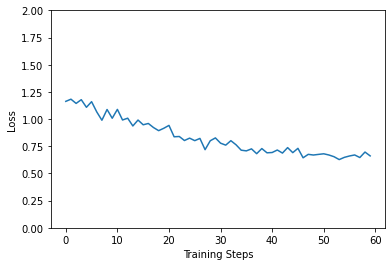

In [27]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

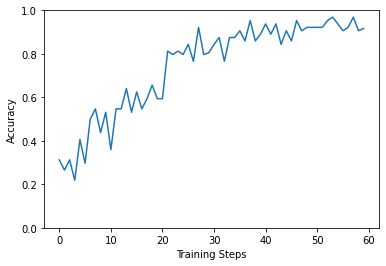

In [28]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [45]:
result=model.evaluate(test_dataset.batch(64).take(400))

7/7 [==============================] - 12s 2s/step - loss: 0.6110 - acc: 0.9850


[[0.03618634 0.9374698  0.02634387]]


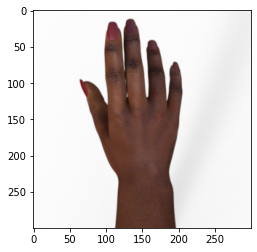

Actual Label: paper
Predicted Label: paper
[[0.98124677 0.01141987 0.00733335]]


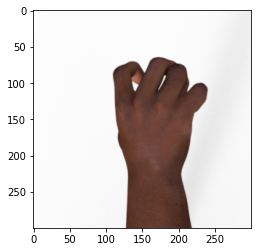

Actual Label: rock
Predicted Label: rock
[[0.01915074 0.00764818 0.9732011 ]]


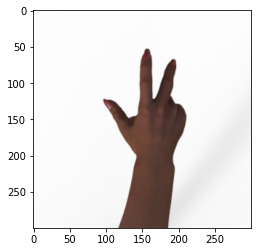

Actual Label: scissors
Predicted Label: scissors
[[0.00374454 0.9152282  0.08102732]]


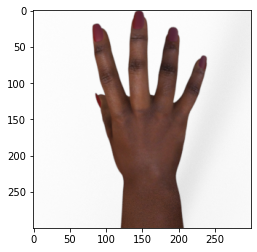

Actual Label: paper
Predicted Label: paper
[[0.02181722 0.03709796 0.9410848 ]]


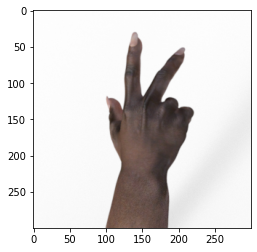

Actual Label: scissors
Predicted Label: scissors
[[0.06109216 0.89663726 0.04227062]]


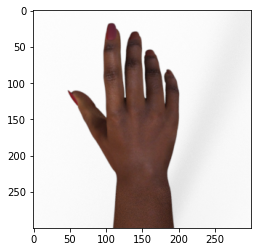

Actual Label: paper
Predicted Label: paper
[[0.03775588 0.06421079 0.8980333 ]]


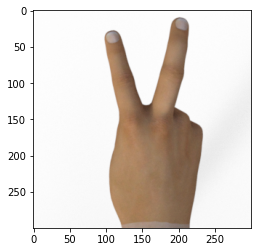

Actual Label: scissors
Predicted Label: scissors
[[0.77285504 0.22560401 0.00154088]]


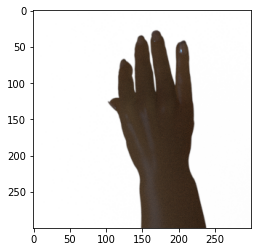

Actual Label: paper
Predicted Label: rock
[[0.82766634 0.14522412 0.02710956]]


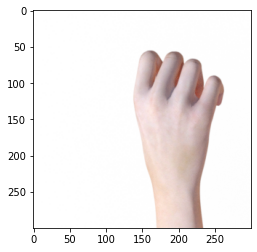

Actual Label: rock
Predicted Label: rock
[[0.0035454  0.10523988 0.8912148 ]]


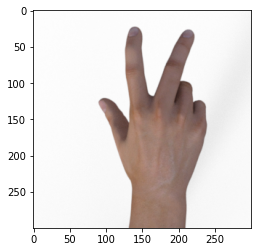

Actual Label: scissors
Predicted Label: scissors


In [46]:
for test_sample in rsp_test.take(10):  
  image, label = test_sample[0], test_sample[1]
  image_scaled, label_arr= scale(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis=0)   

  img = tf.keras.preprocessing.image.img_to_array(image)                    
  pred=model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label: %s" % info.features["label"].names[np.argmax(pred)])


In [48]:
np.argmax(model.predict(test_dataset.batch(64).take(400)),axis=1)

array([2, 0, 2, 2, 1, 0, 0, 1, 2, 0, 2, 1, 2, 2, 0, 0, 1, 0, 1, 2, 0, 2,
       2, 2, 0, 2, 1, 2, 2, 0, 0, 2, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 2, 0,
       0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 2, 2, 0, 0, 2, 1, 2,
       1, 0, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 2, 0, 1, 1, 0, 2, 1, 0, 1, 2,
       0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2,
       1, 0, 1, 1, 0, 2, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 2, 2, 0,
       1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0,
       0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 1, 2, 0, 0, 1, 0, 2, 1, 2, 0, 2, 1,
       2, 0, 0, 2, 0, 0, 1, 2, 1, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 2, 2, 2,
       1, 0, 0, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 2, 0,
       0, 2, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 2,
       2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 2, 1, 2, 1, 0,
       1, 0, 1, 2, 0, 0, 2, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1,
       0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 1,

In [50]:
for f0,f1 in rsp_test.map(scale).batch(400):
  y=np.argmax(f1, axis=1)
  y_pred=np.argmax(model.predict(f0),axis=1)
  print(tf.math.confusion_matrix(labels=y, predictions=y_pred, num_classes=3))

tf.Tensor(
[[135   2   0]
 [  7 123   2]
 [  0   0 131]], shape=(3, 3), dtype=int32)


In [51]:
model.save('./models/', save_format='tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [52]:
!ls -alrt

total 20
drwxr-xr-x 1 root root 4096 Sep 16 16:29 sample_data
drwxr-xr-x 1 root root 4096 Sep 16 16:29 .config
drwxr-xr-x 1 root root 4096 Sep 19 03:05 ..
drwxr-xr-x 1 root root 4096 Sep 19 04:47 .
drwxr-xr-x 4 root root 4096 Sep 19 05:19 models


In [53]:
ls -alrt models

total 2048
drwxr-xr-x 1 root root    4096 Sep 19 04:47 ../
drwxr-xr-x 2 root root    4096 Sep 19 04:47 assets/
drwxr-xr-x 2 root root    4096 Sep 19 05:19 variables/
-rw-r--r-- 1 root root 2079682 Sep 19 05:19 saved_model.pb
drwxr-xr-x 4 root root    4096 Sep 19 05:19 ./


In [54]:
loaded_model = tf.keras.models.load_model('models')

[[0.01353212 0.95290494 0.03356292]]


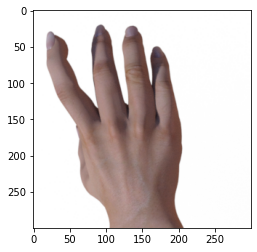

Actual Label: paper
Predicted Label: paper
[[0.01583707 0.9594245  0.02473848]]


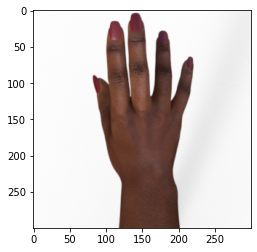

Actual Label: paper
Predicted Label: paper
[[0.8938642  0.07879837 0.02733739]]


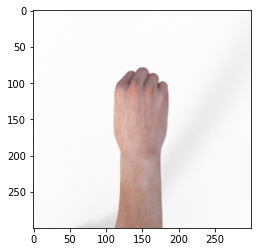

Actual Label: rock
Predicted Label: rock
[[9.9961311e-01 3.7880379e-04 8.1015105e-06]]


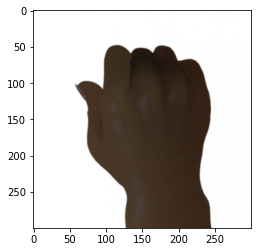

Actual Label: rock
Predicted Label: rock
[[0.00309065 0.03877515 0.95813423]]


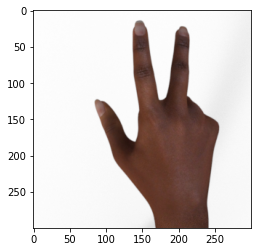

Actual Label: scissors
Predicted Label: scissors
[[0.00653375 0.02865191 0.9648143 ]]


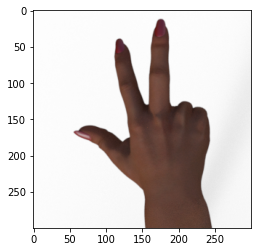

Actual Label: scissors
Predicted Label: scissors
[[9.9230653e-01 7.6324563e-03 6.0980270e-05]]


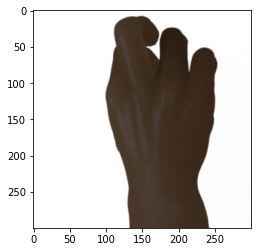

Actual Label: rock
Predicted Label: rock
[[0.00291781 0.924911   0.07217108]]


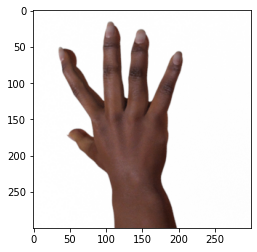

Actual Label: paper
Predicted Label: paper
[[0.87757605 0.10073878 0.02168519]]


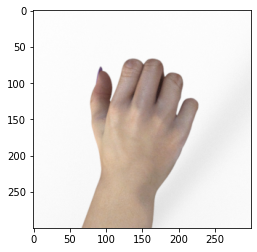

Actual Label: rock
Predicted Label: rock
[[9.9877554e-01 1.2110907e-03 1.3361046e-05]]


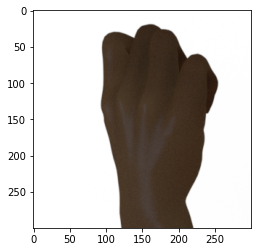

Actual Label: rock
Predicted Label: rock


In [55]:
for test_sample in rsp_test.take(10):  
  image, label = test_sample[0], test_sample[1]
  image_scaled, label_arr= scale(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis=0)   

  img = tf.keras.preprocessing.image.img_to_array(image)                    
  pred=loaded_model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label: %s" % info.features["label"].names[np.argmax(pred)])